In [36]:
# =====Imports =====
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


In [37]:
# =====  Load dataset =====
df = pd.read_csv("mental_health_social_media_dataset.csv")

# Quick look at the data
print(df.shape)
df.head()


(5000, 15)


,person_name,age,date,gender,platform,daily_screen_time_min,social_media_time_min,negative_interactions_count,positive_interactions_count,sleep_hours,physical_activity_min,anxiety_level,stress_level,mood_level,mental_state
0,Reyansh Ghosh,35,1/1/2024,Male,Instagram,320,160,1,2,7.4,28,2,7,6,Stressed
1,Neha Patel,24,1/12/2024,Female,Instagram,453,226,1,3,6.7,15,3,8,5,Stressed
2,Ananya Naidu,26,1/6/2024,Male,Snapchat,357,196,1,2,7.2,24,3,7,6,Stressed
3,Neha Das,66,1/17/2024,Female,Snapchat,190,105,0,1,8.0,41,2,6,6,Stressed
4,Reyansh Banerjee,31,1/28/2024,Male,Snapchat,383,211,1,2,7.1,22,3,7,6,Stressed


We use mental_state as Y' because the teacher requested this target. This is a multi-class classification problem (Healthy / At_Risk / Stressed).
Value counts help us see class imbalance before training models


Most samples belong to the "Stressed" class


In [38]:
# ===== Basic checks =====
print(df.columns.tolist())
print(df["mental_state"].value_counts())


['person_name', 'age', 'date', 'gender', 'platform', 'daily_screen_time_min', 'social_media_time_min', 'negative_interactions_count', 'positive_interactions_count', 'sleep_hours', 'physical_activity_min', 'anxiety_level', 'stress_level', 'mood_level', 'mental_state']
mental_state
Stressed    4601
Healthy      341
At_Risk       58
Name: count, dtype: int64


In [39]:
# =====  Drop non-informative columns =====
# Remove identifiers and unused columns
df = df.drop(columns=["person_name", "date"])


Models work with numeric labels, so we encode mental_state into integers. //
LabelEncoder maps each class name to a number (e.g., Healthy -> 1)
#
dict(zip(...)) prints the mapping so we can interpret results later


In [40]:
# =====  Encode target variable =====
# Convert target labels to numeric values
le_target = LabelEncoder()
df["mental_state_encoded"] = le_target.fit_transform(df["mental_state"])

# Check label mapping
dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))


{'At_Risk': np.int64(0), 'Healthy': np.int64(1), 'Stressed': np.int64(2)}

gender and platform are categorical, so we convert them to dummy variables
#
One-hot encoding avoids giving an artificial numeric order to categories
#
This makes features usable for all three models

In [41]:
# =====   Encode categorical features =====
# Encode categorical input features
df_encoded = pd.get_dummies(df, columns=["gender", "platform"], drop_first=True)

print(df_encoded.shape)


(5000, 20)


↑ Categorical features encoded using one-hot encoding

X contains input features used for prediction ----//--- Y is the target label (encoded mental_state)
--- / ---
We drop target columns from X to prevent data leakage


In [42]:
# =====  Define features and target =====
X = df_encoded.drop(columns=["mental_state", "mental_state_encoded"])
y = df_encoded["mental_state_encoded"]

print(X.shape, y.shape)


(5000, 18) (5000,)


↑ Feature matrix and target vector prepared for modeling

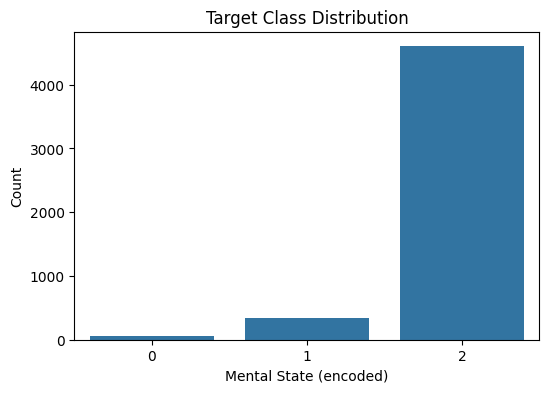

In [43]:
# ===== Check target distribution =====
# Visualize class imbalance
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Target Class Distribution")
plt.xlabel("Mental State (encoded)")
plt.ylabel("Count")
plt.show()


Split data into train and test sets to evaluate on unseen samples --/ --  stratify=y keeps the same class proportions in both sets


In [44]:
# =====  Train-test split =====
# Split data while preserving class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)


(4000, 18) (1000, 18)


↑# Train (4000) and test (1000)


In [45]:
# ===========================================
# ===== First Model Random Forest model =====
# ===========================================

from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)


In [46]:
# ===== Train and predict =====
# Train the model
rf_model.fit(X_train, y_train)

# Predict on test set
rf_pred = rf_model.predict(X_test)


Accuracy is the overall percent of correct predictions
#
Macro F1 averages F1 across classes, treating each class equally --/--- mental_state shows strong class imbalance (Stressed >> Healthy, At_Risk)
---/--- Macro F1 gives equal importance to minority classes


In [47]:
# =====  Evaluation metrics =====
rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average="macro")  #Macro F1 forces the model to perform well on minority classes.

print("Random Forest Accuracy:", round(rf_acc, 4))
print("Random Forest F1-macro:", round(rf_f1, 4))


Random Forest Accuracy: 1.0
Random Forest F1-macro: 1.0


↑ # Perfect performance likely due to strong relationship between features and target

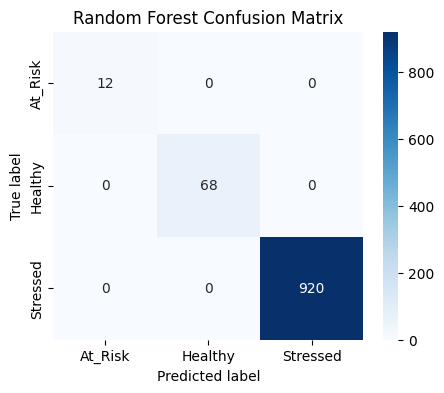

In [48]:
# =====  Confusion matrix =====
cm = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le_target.classes_,
    yticklabels=le_target.classes_
)

plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [49]:
# ===== Classification report =====
print(classification_report(
    y_test,
    rf_pred,
    target_names=le_target.classes_
))


              precision    recall  f1-score   support

     At_Risk       1.00      1.00      1.00        12
     Healthy       1.00      1.00      1.00        68
    Stressed       1.00      1.00      1.00       920

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



↑ Perfect scores may indicate very strong feature-target relationships in this dataset


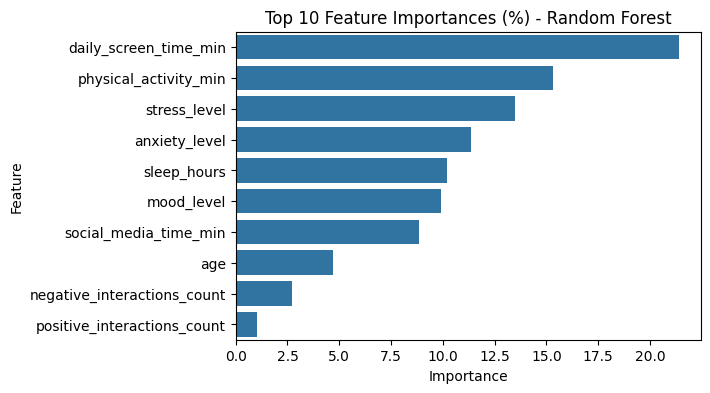

In [72]:
# ===== Feature importance =====
# Convert feature importances to percentages for better interpretation
importances = rf_model.feature_importances_*100
feature_names = X.columns

rf_importance = pd.Series(importances, index=feature_names)
rf_importance = rf_importance.sort_values(ascending=False).head(10)

plt.figure(figsize=(6,4))
sns.barplot(x=rf_importance.values, y=rf_importance.index)
plt.title("Top 10 Feature Importances (%) - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


↑Daily Screen time and activity levels dominate feature importance in Random Forest


In [51]:
# ===========================================
# ===== Second Model LightGBM  model =====
# ===========================================

import lightgbm as lgb

# Initialize LightGBM classifier
lgbm_model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
    class_weight="balanced",
    verbose=-1
)


In [52]:
# ===== Train and predict =====
# Train the model
lgbm_model.fit(X_train, y_train)

# Predict on test set
lgbm_pred = lgbm_model.predict(X_test)


In [53]:
# ===== Evaluation metrics =====
lgbm_acc = accuracy_score(y_test, lgbm_pred)
lgbm_f1 = f1_score(y_test, lgbm_pred, average="macro")

print("LightGBM Accuracy:", round(lgbm_acc, 4))
print("LightGBM F1-macro:", round(lgbm_f1, 4))


LightGBM Accuracy: 0.998
LightGBM F1-macro: 0.9673


↑ High accuracy but lower macro F1 due to minority class errors
↑ # Macro F1 balances performance across all classes, not dominated by majority


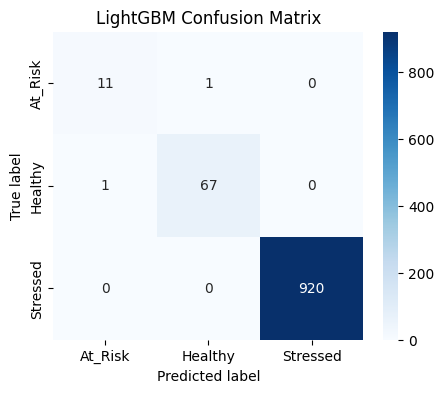

In [54]:
# =====  Confusion matrix =====
cm_lgbm = confusion_matrix(y_test, lgbm_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_lgbm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le_target.classes_,
    yticklabels=le_target.classes_
)

plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


↑ # Confusion matrix shows how predictions compare against true labels
#
↑ Most errors occur between At_Risk and Healthy classes
#
↑ Majority class Stressed is classified almost perfectly
#
↑ Minority class mistakes strongly affect macro F1 score

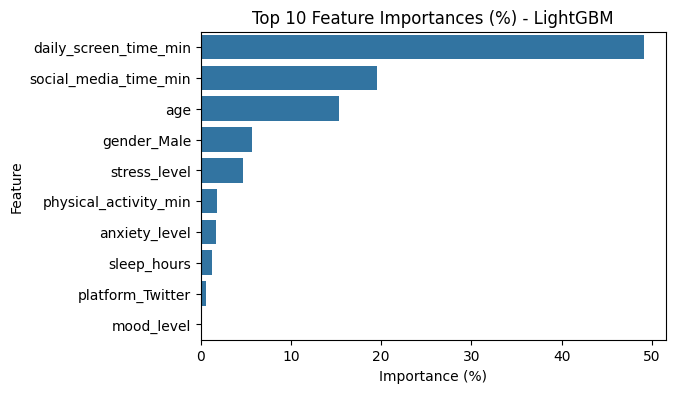

In [55]:
# ===== Feature importance (LightGBM) =====

# Feature importance converted to percentages for easier interpretation
lgbm_importances = lgbm_model.feature_importances_.astype(float)
lgbm_importances = (lgbm_importances / lgbm_importances.sum()) * 100

lgbm_top10 = (
    pd.Series(lgbm_importances, index=X.columns)
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(6,4))
sns.barplot(x=lgbm_top10.values, y=lgbm_top10.index)
plt.title("Top 10 Feature Importances (%) - LightGBM")
plt.xlabel("Importance (%)")
plt.ylabel("Feature")
plt.show()


In [56]:
# LightGBM emphasizes screen time variables more strongly than Random Forest
# Daily and social media usage dominate boosted tree decisions
# Emotional variables play a secondary role in this model
# Different importance patterns reflect model-specific learning behavior


In [57]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [58]:

# ===========================================
# ===== Third Model CatBoost  model =====
# ===========================================

from catboost import CatBoostClassifier

# Initialize CatBoost classifier with manual class weights
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function="MultiClass",
    class_weights=[10, 2, 1],
    random_seed=42,
    verbose=False
)

In [59]:
# ===== Train and predict =====
cat_model.fit(X_train, y_train)

cat_pred = cat_model.predict(X_test).ravel()


In [60]:
# ===== Evaluation metrics =====
cat_acc = accuracy_score(y_test, cat_pred)
cat_f1 = f1_score(y_test, cat_pred, average="macro")

print("CatBoost Accuracy:", round(cat_acc, 4))
print("CatBoost F1-macro:", round(cat_f1, 4))


CatBoost Accuracy: 0.999
CatBoost F1-macro: 0.9842


In [61]:
# CatBoost balances accuracy and macro F1 better than previous models

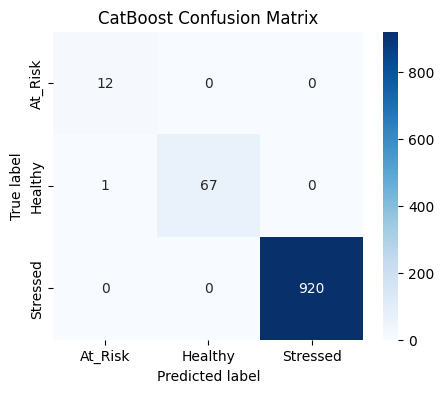

In [62]:
# =====Confusion matrix =====
cm_cat = confusion_matrix(y_test, cat_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_cat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le_target.classes_,
    yticklabels=le_target.classes_
)

plt.title("CatBoost Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


#
CatBoost shows strong classification performance across all mental state classes
#
Minority class At_Risk is fully detected without misclassification
#
Small confusion appears between Healthy and At_Risk, expected due to similarity
#
High accuracy is supported by balanced performance across classes


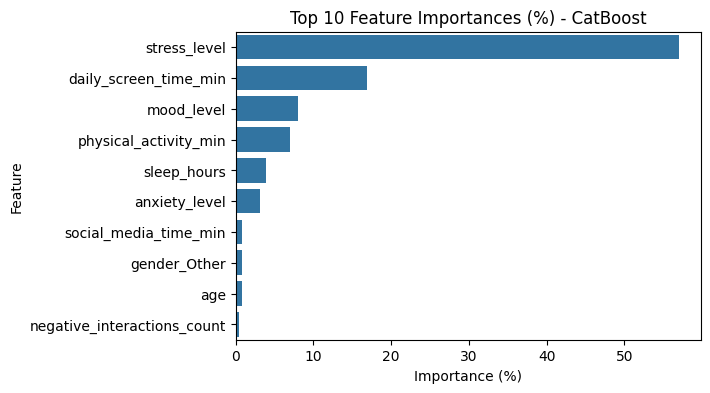

In [63]:
# ===== Feature importance (percentages) =====

# Convert CatBoost importances to percentages for interpretation
cat_importances = cat_model.get_feature_importance()
cat_importances = (cat_importances / cat_importances.sum()) * 100

cat_top10 = (
    pd.Series(cat_importances, index=X.columns)
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(6,4))
sns.barplot(x=cat_top10.values, y=cat_top10.index)
plt.title("Top 10 Feature Importances (%) - CatBoost")
plt.xlabel("Importance (%)")
plt.ylabel("Feature")
plt.show()


#
Stress level dominates predictions, strongly defining mental state categories
#
Screen time remains a key behavioral signal influencing model decisions
#
Emotional and behavioral features jointly explain mental health outcomes
#
CatBoost relies on fewer, stronger features compared to other models


In [64]:
# ===========================================
# ===== Final model comparison table =====
# ===========================================

results_df = pd.DataFrame({
    "Model": ["Random Forest", "LightGBM", "CatBoost"],
    "Accuracy": [rf_acc, lgbm_acc, cat_acc],
    "F1_macro": [rf_f1, lgbm_f1, cat_f1]
})

results_df

,Model,Accuracy,F1_macro
0,Random Forest,1.000,1.000000
1,LightGBM,0.998,0.967320
2,CatBoost,0.999,0.984198


Random Forest achieves perfect scores, indicating possible overfitting to this dataset
#
LightGBM shows lower macro F1, mainly affected by minority class performance
#
CatBoost maintains high accuracy with improved balance across classes


/tmp/ipython-input-4139687771.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


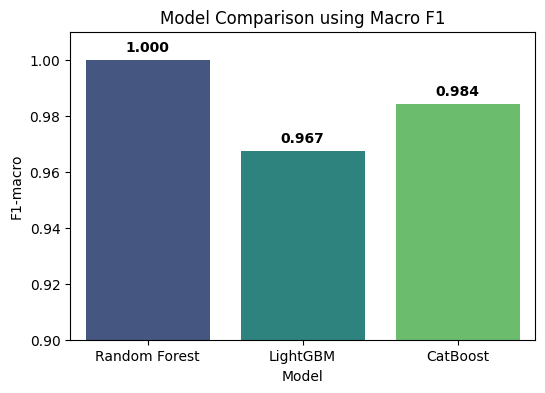

In [65]:
# =====  Model comparison plot =====
plt.figure(figsize=(6,4))
sns.barplot(
    data=results_df,
    x="Model",
    y="F1_macro",
    palette="viridis"
)

plt.title("Model Comparison using Macro F1")
plt.ylabel("F1-macro")
plt.ylim(0.9, 1.01)

for i, v in enumerate(results_df["F1_macro"]):
    plt.text(i, v + 0.003, f"{v:.3f}", ha="center", fontweight="bold")

plt.show()


#
Macro F1 comparison highlights differences beyond raw accuracy values
#
CatBoost outperforms LightGBM in handling minority mental state classes
#
Random Forest dominance suggests strong feature separability in the dataset


In [66]:
# =====  Final model selection =====
best_model_name = results_df.sort_values("F1_macro", ascending=False).iloc[0]["Model"]
best_model_name


'Random Forest'

In [67]:
# ===== Build plot_df for grouped bar chart =====
plot_df = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
plot_df.head()


,Model,Metric,Score
0,Random Forest,Accuracy,1.00000
1,LightGBM,Accuracy,0.99800
2,CatBoost,Accuracy,0.99900
3,Random Forest,F1_macro,1.00000
4,LightGBM,F1_macro,0.96732


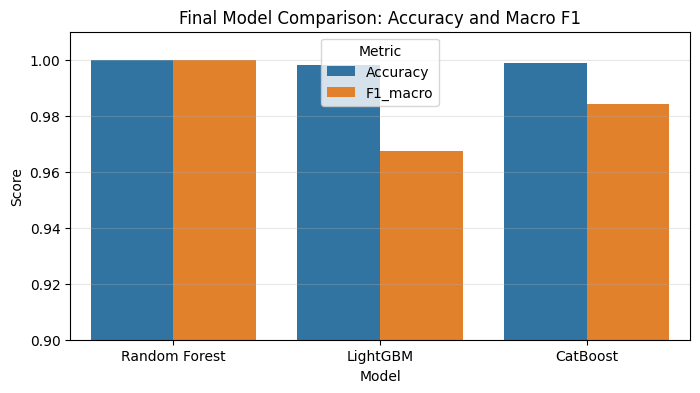

In [68]:
# Plot grouped bar chart for final model comparison
plt.figure(figsize=(8,4))
sns.barplot(data=plot_df, x="Model", y="Score", hue="Metric")
plt.title("Final Model Comparison: Accuracy and Macro F1")
plt.ylim(0.9, 1.01)
plt.ylabel("Score")
plt.grid(axis="y", alpha=0.3)
plt.show()



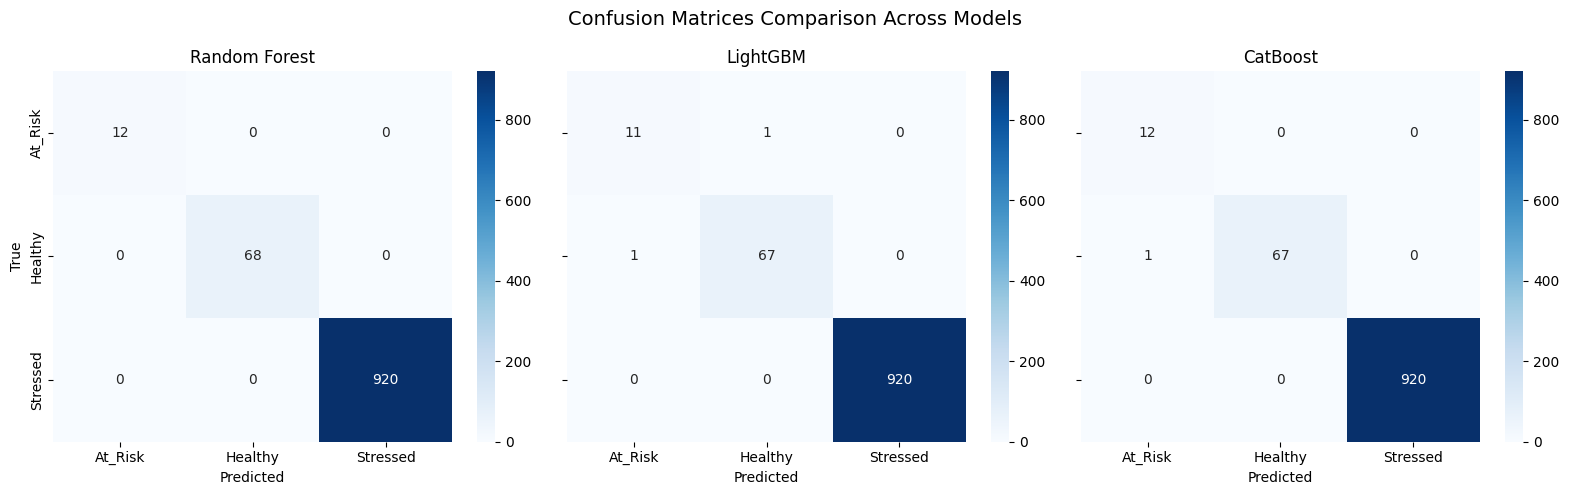

In [69]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrices
cm_rf = confusion_matrix(y_test, rf_model.predict(X_test))
cm_lgbm = confusion_matrix(y_test, lgbm_model.predict(X_test))
cm_cat = confusion_matrix(y_test, cat_model.predict(X_test))

labels = le_target.classes_

# Plot aligned heatmaps
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

sns.heatmap(
    cm_rf, annot=True, fmt="d", cmap="Blues",
    xticklabels=labels, yticklabels=labels, ax=axes[0]
)
axes[0].set_title("Random Forest")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(
    cm_lgbm, annot=True, fmt="d", cmap="Blues",
    xticklabels=labels, yticklabels=labels, ax=axes[1]
)
axes[1].set_title("LightGBM")
axes[1].set_xlabel("Predicted")

sns.heatmap(
    cm_cat, annot=True, fmt="d", cmap="Blues",
    xticklabels=labels, yticklabels=labels, ax=axes[2]
)
axes[2].set_title("CatBoost")
axes[2].set_xlabel("Predicted")

plt.suptitle("Confusion Matrices Comparison Across Models", fontsize=14)
plt.tight_layout()
plt.show()


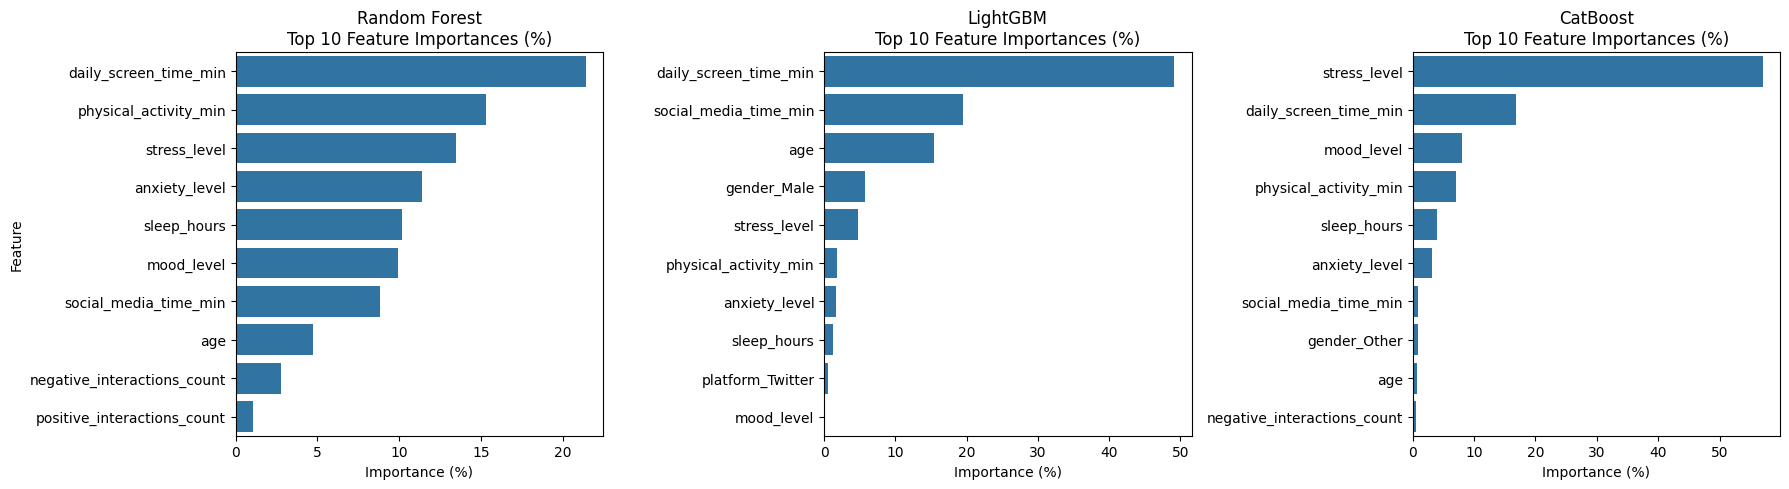

In [73]:
# ===== Top 10 Feature Importances (%) - All Models (normalized) =====

def top10_percent(series, top_n=10):
    s = series.astype(float)
    s = (s / s.sum()) * 100
    return s.sort_values(ascending=False).head(top_n)

# Random Forest
rf_series = pd.Series(rf_model.feature_importances_, index=X.columns)
rf_top10 = top10_percent(rf_series)

# LightGBM (needs normalization!)
lgbm_series = pd.Series(lgbm_model.feature_importances_, index=X.columns)
lgbm_top10 = top10_percent(lgbm_series)

# CatBoost (needs normalization!)
cat_series = pd.Series(cat_model.get_feature_importance(), index=X.columns)
cat_top10 = top10_percent(cat_series)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(x=rf_top10.values, y=rf_top10.index, ax=axes[0])
axes[0].set_title("Random Forest\nTop 10 Feature Importances (%)")
axes[0].set_xlabel("Importance (%)")
axes[0].set_ylabel("Feature")

sns.barplot(x=lgbm_top10.values, y=lgbm_top10.index, ax=axes[1])
axes[1].set_title("LightGBM\nTop 10 Feature Importances (%)")
axes[1].set_xlabel("Importance (%)")
axes[1].set_ylabel("")

sns.barplot(x=cat_top10.values, y=cat_top10.index, ax=axes[2])
axes[2].set_title("CatBoost\nTop 10 Feature Importances (%)")
axes[2].set_xlabel("Importance (%)")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()



In [70]:
## ======================================================
# What-If Simulator Instructions
# ------------------------------------------------------
# Fill realistic daily values using hours + minutes fields
# Minutes fields must be between 0 and 59
# Click "Run" to see predicted mental state and probabilities
# ======================================================

#@title What-if inputs (intuitive)
age = 20  #@param {type:"integer",min:18,max:70,step:1}

screen_hours = 10  #@param {type:"integer",min:0,max:12,step:1}
screen_minutes = 2  #@param {type:"integer",min:0,max:59,step:1}

social_hours = 4  #@param {type:"integer",min:0,max:10,step:1}
social_minutes = 50  #@param {type:"integer",min:0,max:59,step:1}

sleep_hours = 12  #@param {type:"number",min:0,max:12,step:0.5}

activity_hours = 4  #@param {type:"integer",min:0,max:3,step:1}
activity_minutes = 20  #@param {type:"integer",min:0,max:59,step:1}

stress_1_to_10 = 5  #@param {type:"integer",min:1,max:10,step:1}
anxiety_1_to_4 = 4  #@param {type:"integer",min:1,max:4,step:1}
mood_1_to_10 = 3  #@param {type:"integer",min:1,max:10,step:1}

negative_interactions = 2  #@param {type:"integer",min:0,max:5,step:1}
positive_interactions = 1  #@param {type:"integer",min:0,max:10,step:1}

gender = "Female"  #@param ["Male","Female","Other"]
platform = "Twitter"  #@param ["Instagram","Snapchat","Facebook","TikTok","WhatsApp","YouTube","Twitter"]


# ===== Input validation =====
# Minutes fields should be 0-59
if screen_minutes > 59 or social_minutes > 59 or activity_minutes > 59:
    print("Warning: minutes fields must be between 0 and 59.")

# Convert to minutes (matches training units)
daily_screen_time_min = (screen_hours * 60) + screen_minutes
social_media_time_min = (social_hours * 60) + social_minutes
physical_activity_min = (activity_hours * 60) + activity_minutes

# Print converted values to confirm inputs
print("Screen minutes:", daily_screen_time_min)
print("Social minutes:", social_media_time_min)
print("Activity minutes:", physical_activity_min)

# Sanity check: social time should not exceed total screen time
if social_media_time_min > daily_screen_time_min:
    print("Warning: Social media time exceeds total screen time.")

# Build a single-row input with the exact training columns
user = pd.DataFrame(0, index=[0], columns=X.columns)

# Fill numeric features
user["age"] = age
user["daily_screen_time_min"] = daily_screen_time_min
user["social_media_time_min"] = social_media_time_min
user["sleep_hours"] = sleep_hours
user["physical_activity_min"] = physical_activity_min
user["stress_level"] = stress_1_to_10
user["anxiety_level"] = anxiety_1_to_4
user["mood_level"] = mood_1_to_10
user["negative_interactions_count"] = negative_interactions
user["positive_interactions_count"] = positive_interactions

# Set one-hot flags safely
gender_col = f"gender_{gender}"
platform_col = f"platform_{platform}"

if gender_col in user.columns:
    user[gender_col] = 1

if platform_col in user.columns:
    user[platform_col] = 1

# Predict with CatBoost
pred_idx = int(cat_model.predict(user).ravel()[0])
pred_label = le_target.inverse_transform([pred_idx])[0]

probs = cat_model.predict_proba(user)[0]
prob_dict = {le_target.inverse_transform([i])[0]: round(float(p)*100, 2) for i, p in enumerate(probs)}

print("--- SIMULATOR REPORT ---")
print("Prediction:", pred_label)
print("Class probabilities (%):", prob_dict)



Screen minutes: 602
Social minutes: 290
Activity minutes: 260
--- SIMULATOR REPORT ---
Prediction: At_Risk
Class probabilities (%): {'At_Risk': 55.22, 'Healthy': 12.72, 'Stressed': 32.06}
